# 마스크 착용 상태 분류
(Aistages Competition)  
카메라로 촬영한 사람 얼굴 이미지의 마스크 착용여부를 판단하는 Task

## 1. 대회 개요

### 1.1. 배경

<img src="./images/about_competition.png" width=600px>

### 1.2. 평가방법 (Metric)

<img src="./images/about_competition2.png" width=600px>

### 1.3. 데이터 셋

<img src="./images/sample_image.png" width=600px/>  

- 전체 사람 수 : 4,500명  
- 한 사람 당 사진 갯수 : 7개 (마스크 착용 5, 미착용 1, 잘못착용 1)  
- 이미지 크기 : (384, 512)  
- 결과 클래스 (Label)  

<img src="./images/label.png" width=600px>  

## 2. 프로젝트

<img src="./images/flow.png" width=600px>  

- 데이터 이해
- Dataset 생성
- Model(Module) 생성
- Train (학습)
- 평가

### 2.1. 데이터 이해 (EDA)

EDA과정으로 주어진 데이터의 수치나 분포등을 통해 이해하는 단계

보다 다양한 EDA데이터는 강의를 통해 얻은 './sample_code/2_EDA.ipynb' 파일을 참고

In [1]:
train_dir = '/opt/ml/input/data/train/'

In [2]:
import pandas as pd
import os

In [3]:
df = pd.read_csv(os.path.join(train_dir, 'train.csv'))
df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


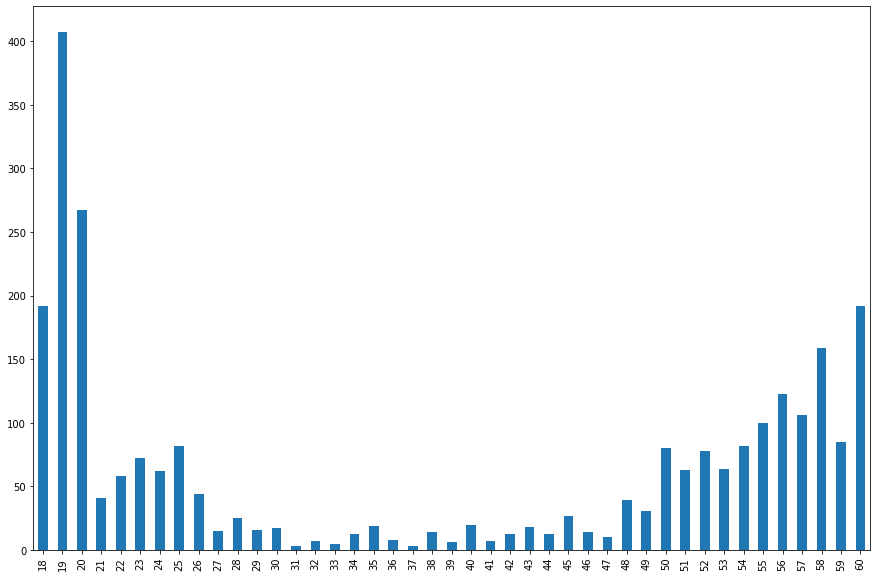

In [18]:
# 나이 그래프
df.age.value_counts().sort_index().plot(kind='bar', figsize=(15,10))

~30        1281
30 ~ 60    1227
60 ~        192
Name: age_range, dtype: int64


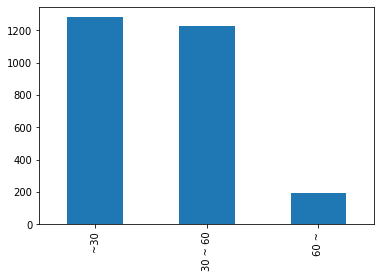

In [19]:
df['age_range'] = df['age'].apply(lambda x: '~30' if x < 30 else ('60 ~' if x >= 60 else '30 ~ 60'))
print(df.age_range.value_counts())
df.age_range.value_counts().plot(kind='bar')

In [59]:
# 나이 그래프
#print(df.gender.value_counts())
#df.loc[df['gender'] == 'female']['age_range'].value_counts()
#print('------------------------------------------------------')
#grouped = df.groupby(level=['gender', 'age_range'])
#print(df.loc[df['gender'] == 'female']['age_range'].value_counts())
#print(df.loc[df['gender'] == 'male']['age_range'].value_counts())
df.loc[df['gender'] == 'female'].loc[df['age_range'] == '60 ~']

,id,gender,race,age,path,age_range
443,001063,female,Asian,60,001063_female_Asian_60,60 ~
477,001102,female,Asian,60,001102_female_Asian_60,60 ~
480,001106,female,Asian,60,001106_female_Asian_60,60 ~
540,001172,female,Asian,60,001172_female_Asian_60,60 ~
671,001363,female,Asian,60,001363_female_Asian_60,60 ~
...,...,...,...,...,...,...
2161,005446,female,Asian,60,005446_female_Asian_60,60 ~
2168,005453,female,Asian,60,005453_female_Asian_60,60 ~
2175,005461,female,Asian,60,005461_female_Asian_60,60 ~
2209,005504,female,Asian,60,005504_female_Asian_60,60 ~


- 위 과정을 통해 클래스 (라벨)을 분류하는데 기준이 되는 나이 분포가 고르지 않음을 알 수 있었다.  
  => 60세의 데이터가 비교적 평균보다 많이 있지만 60세 이상의 나이가 60세만 있어 데이터의 불균형을 볼 수 있었다.  
  => 30~60 세의 데이터가 매우 넓게 분포되어 있음을 볼 수 있었다.
- sample_code를 보며 마스크의 색상이 단색인 경우가 대부분이다 보니 특정영역에 같은 색상으로 분포된 것을 고려  
  => mask5 파일명의 데이터의 경우 불규칙적인 마스크 디자인을 착용한 것을 확인
  => 마스크의 색상 또한 다양한 색으로 보임(검정, 하양, 하늘색 등등)
- 모든 사람들이 정면을 보고 정자세로 촬영한 것으로 사람의 얼굴 영역만 추출하면 좋을 것 같음
  => 옷, 배경 등의 영향을 줄이기 위함

### 2.2. DataSet 만들기

torch.utils.data의 Dataset을 상속받아 Mask DataSet을 만들기.  
- 주어진 데이터로부터 Labeling하기 (파일명 - 마스크착용상태 / Age - 나이범위 / gendar - 성별)
- 가능한 Augmentation 하여 데이터 늘리기

#### 2.2.1. 주어진 데이터 Labeling하기

In [4]:
import torch
import pandas as pd

In [5]:
print(train_dir)
df = pd.read_csv(os.path.join(train_dir, 'train.csv'))
df.head()

/opt/ml/input/data/train/


,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [6]:
# age로 범위지정해서 새로운 column 만들기
df['age_range'] = df['age'].apply(lambda x: 'younger then 30' if x < 30 else ('older then 60' if x >= 60 else 'between 30 and 60'))

# fullpath
df['full_path'] = df['path'].apply(lambda x: os.path.join(train_dir, 'images', x))

df.head()

,id,gender,race,age,path,age_range,full_path
0,000001,female,Asian,45,000001_female_Asian_45,between 30 and 60,/opt/ml/input/data/train/images/000001_female_...
1,000002,female,Asian,52,000002_female_Asian_52,between 30 and 60,/opt/ml/input/data/train/images/000002_female_...
2,000004,male,Asian,54,000004_male_Asian_54,between 30 and 60,/opt/ml/input/data/train/images/000004_male_As...
3,000005,female,Asian,58,000005_female_Asian_58,between 30 and 60,/opt/ml/input/data/train/images/000005_female_...
4,000006,female,Asian,59,000006_female_Asian_59,between 30 and 60,/opt/ml/input/data/train/images/000006_female_...


In [8]:
from sklearn.model_selection import train_test_split

# 817 732 109 549 410 83 : 2700
# 163 146 22 110 82 17 : 540

VAL_SPLIT = 0.2

df_t1, df_v1 = train_test_split(df.loc[df['gender'] == 'female'].loc[df['age_range'] == 'younger then 30'], test_size=VAL_SPLIT, random_state=42)
df_t2, df_v2 = train_test_split(df.loc[df['gender'] == 'female'].loc[df['age_range'] == 'between 30 and 60'], test_size=VAL_SPLIT, random_state=42)
df_t3, df_v3 = train_test_split(df.loc[df['gender'] == 'female'].loc[df['age_range'] == 'older then 60'], test_size=VAL_SPLIT, random_state=42)
df_t4, df_v4 = train_test_split(df.loc[df['gender'] == 'male'].loc[df['age_range'] == 'younger then 30'], test_size=VAL_SPLIT, random_state=42)
df_t5, df_v5 = train_test_split(df.loc[df['gender'] == 'male'].loc[df['age_range'] == 'between 30 and 60'], test_size=VAL_SPLIT, random_state=42)
df_t6, df_v6 = train_test_split(df.loc[df['gender'] == 'male'].loc[df['age_range'] == 'older then 60'], test_size=VAL_SPLIT, random_state=42)

train_df = pd.concat([df_t1, df_t2, df_t3, df_t4, df_t5, df_t6])
validation_df = pd.concat([df_v1, df_v2, df_v3, df_v4, df_v5, df_v6])

print(len(train_df))
print(len(validation_df))

2158
542


In [64]:
# split train and validation set
#from sklearn.model_selection import train_test_split

#VAL_SPLIT=0.2

#train_df, validation_df = train_test_split(df, test_size=VAL_SPLIT, random_state=2021) # random_state is seed to fix data
#print(f'train : {len(train_df)}, validation : {len(validation_df)}')
#train_df.head()

In [9]:
from tqdm.notebook import tqdm

class_dict = {
    "Wear": {"male": {"younger then 30": "0", "between 30 and 60": "1", "older then 60": "2"}
            ,"female": {"younger then 30": "3", "between 30 and 60": "4", "older then 60": "5"}},
    "incorrect": {"male": {"younger then 30": "6", "between 30 and 60": "7", "older then 60": "8"}
            ,"female": {"younger then 30": "9", "between 30 and 60": "10", "older then 60": "11"}},
    "Not Wear": {"male": {"younger then 30": "12", "between 30 and 60": "13", "older then 60": "14"}
            ,"female": {"younger then 30": "15", "between 30 and 60": "16", "older then 60": "17"}}
}

train_class_df = pd.DataFrame([], columns = ['gender', 'age_range', 'wearing_status', 'class', 'age', 'race', 'path', 'img_full_path', 'full_path'])
validation_class_df = pd.DataFrame([], columns = ['class', 'img_full_path'])

for index, row in tqdm(train_df.iterrows()):
    img_dir_list = os.listdir(row.full_path)
    img_dir_list = [img_file for img_file in img_dir_list if not img_file.startswith('.')] # remove hidden files
    for img_file in img_dir_list:
        row['img_full_path'] = os.path.join(row.full_path, img_file)
        row['wearing_status'] = 'incorrect' if 'incorrect_mask' in img_file else ('Not Wear' if 'normal' in img_file else 'Wear')
        row['class'] = class_dict[row.wearing_status][row.gender][row.age_range]
        train_class_df = train_class_df.append(row, ignore_index=True)

for index, row in tqdm(validation_df.iterrows()):
    img_dir_list = os.listdir(row.full_path)
    img_dir_list = [img_file for img_file in img_dir_list if not img_file.startswith('.')] # remove hidden files
    for img_file in img_dir_list:
        row['img_full_path'] = os.path.join(row.full_path, img_file)
        row['wearing_status'] = 'incorrect' if 'incorrect_mask' in img_file else ('Not Wear' if 'normal' in img_file else 'Wear')
        row['class'] = class_dict[row.wearing_status][row.gender][row.age_range]
        validation_class_df = validation_class_df.append(row, ignore_index=True)        
        
# label 값을 위한 수치 Age : 0, 1, 2 / Gender : 0, 3 / Mask 0, 6, 12  프로젝트 소스로 옮길땐 이 방법으로 수정(더 효율적임)
#df['age_point'] = df['age'].apply(lambda x: 0 if x < 30 else (2 if x >= 60 else 1))
#df['gender_point'] = df['gender'].apply(lambda x: 0 if x.lower() == 'male' else 3)
#row['wearing_status_point'] = 'incorrect' if 'incorrect_mask' in img_file else ('Not Wear' if 'normal' in img_file else 'Wear')        

print(f'train : {len(train_class_df)}, validation : {len(validation_class_df)}') # 15120, 3780


train : 15106, validation : 3794


In [15]:
train_class_df.head()
print(train_class_df.loc[train_class_df['gender'] == 'female']['age_range'].value_counts())
print(validation_class_df.loc[validation_class_df['gender'] == 'female']['age_range'].value_counts())

between 30 and 60    4571
younger then 30      4095
older then 60         609
Name: age_range, dtype: int64
between 30 and 60    1148
younger then 30      1029
older then 60         154
Name: age_range, dtype: int64


In [12]:
validation_class_df.head()

,class,img_full_path,age,age_range,full_path,gender,id,path,race,wearing_status
0,3,/opt/ml/input/data/train/images/003093_female_...,19.0,younger then 30,/opt/ml/input/data/train/images/003093_female_...,female,003093,003093_female_Asian_19,Asian,Wear
1,15,/opt/ml/input/data/train/images/003093_female_...,19.0,younger then 30,/opt/ml/input/data/train/images/003093_female_...,female,003093,003093_female_Asian_19,Asian,Not Wear
2,3,/opt/ml/input/data/train/images/003093_female_...,19.0,younger then 30,/opt/ml/input/data/train/images/003093_female_...,female,003093,003093_female_Asian_19,Asian,Wear
3,9,/opt/ml/input/data/train/images/003093_female_...,19.0,younger then 30,/opt/ml/input/data/train/images/003093_female_...,female,003093,003093_female_Asian_19,Asian,incorrect
4,3,/opt/ml/input/data/train/images/003093_female_...,19.0,younger then 30,/opt/ml/input/data/train/images/003093_female_...,female,003093,003093_female_Asian_19,Asian,Wear


In [16]:
# csv 파일로 저장
if os.path.isfile('./base_dataset/train_class_df.csv'):
    os.remove('./base_dataset/train_class_df.csv')
if os.path.isfile('./base_dataset/validation_class_df.csv'):
    os.remove('./base_dataset/validation_class_df.csv')
    
train_class_df.to_csv('./base_dataset/train_class_df.csv')
validation_class_df.to_csv('./base_dataset/validation_class_df.csv')

In [3]:
########################################################################################################################################################
######################################재시작시 시작점###################################################################################################
########################################################################################################################################################

In [1]:
data_path = {
    'train': './base_dataset/train_class_df.csv',
    'validation': './base_dataset/validation_class_df.csv'
}

In [2]:
import os

import random
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms

from PIL import Image

# SEED 를 고정
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

seed = 42
seed_everything(seed)

#### 2.2.2. Dataset 만들기

In [3]:
import cv2

class Mask(Dataset):
    def __init__(self, method, transform, train=True):
        self.data = pd.read_csv(data_path[method])
        self.transform = transform
        self.train = train
        
        self.X = self.data['img_full_path']
        self.y = self.data['class']
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        #print(self.X[idx])
        img = cv2.imread(self.X[idx])
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        face = cascade.detectMultiScale(rgb)
        if len(face) == 0:
            croped = rgb[100:400, 80:280]
        else:
            for x, y, w, h in face:
                if w < 100:
                    croped = rgb[100:400, 80:280]
                    break
                croped = rgb[max(0,y-50):min(y+h+20, 512), x:x+w]
        
        crop_img = Image.fromarray(croped)
        crop_img = transforms.Resize((300,200))(crop_img)
        
        X = self.transform(crop_img)
        y = self.y[idx]

        X = torch.tensor(X, dtype=torch.float)
        y = torch.tensor(y, dtype=torch.long)
        
        if not self.train:
            X = torch.tensor(X, dtype=torch.float)
            return X.clone().detach()
            #return torch.tensor(X, dtype=torch.float)
        #return torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.long)
        return X.clone().detach(), y.clone().detach()

#         img = Image.open(self.X[idx])
        
#         X = self.transform(img)
#         y = self.y[idx]

#         X = torch.tensor(X, dtype=torch.float)
#         y = torch.tensor(y, dtype=torch.long)
        
#         if not self.train:
#             X = torch.tensor(X, dtype=torch.float)
#             return X.clone().detach()
#             #return torch.tensor(X, dtype=torch.float)
#         #return torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.long)
#         return X.clone().detach(), y.clone().detach()

In [4]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2))
])

In [5]:
train_dataset = Mask(method='train', transform=transform, train=True)
validation_dataset = Mask(method='validation', transform=transform, train=True)

#### 2.2.3. DataLoader 만들기

In [6]:
from torch.utils.data.sampler import SubsetRandomSampler

BATCH_SIZE = 32

seed_everything(seed)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [7]:
train_dataset[11]
# sample_img, sample_label = next(iter(train_loader))
# sample_img

/opt/ml/input/data/train/images/003070_female_Asian_20/mask3.jpg


<ipython-input-3-42cb521d51ab>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


(tensor([[[ 0.6765,  0.6765,  0.6765,  ...,  0.0882,  0.1667,  0.3627],
          [ 0.6765,  0.6765,  0.6765,  ...,  0.1078,  0.1667,  0.2255],
          [ 0.6765,  0.6765,  0.6765,  ...,  0.2059,  0.2255,  0.1275],
          ...,
          [-2.3039, -2.2843, -2.2647,  ..., -1.4804, -1.4804, -1.4804],
          [-2.3039, -2.2843, -2.2647,  ..., -1.4804, -1.4804, -1.4804],
          [-2.3039, -2.2843, -2.2451,  ..., -1.4804, -1.4804, -1.4804]],
 
         [[ 0.6569,  0.6569,  0.6569,  ...,  0.0686,  0.1471,  0.3431],
          [ 0.6569,  0.6569,  0.6569,  ...,  0.0882,  0.1471,  0.2059],
          [ 0.6569,  0.6569,  0.6569,  ...,  0.1863,  0.2059,  0.1078],
          ...,
          [-2.3039, -2.2843, -2.2647,  ..., -1.6176, -1.6176, -1.6176],
          [-2.3039, -2.2843, -2.2647,  ..., -1.6176, -1.6176, -1.6176],
          [-2.3039, -2.2843, -2.2843,  ..., -1.6176, -1.6176, -1.6176]],
 
         [[ 0.5784,  0.5784,  0.5784,  ..., -0.0294,  0.0490,  0.2451],
          [ 0.5784,  0.5784,

### 2.3. Model 만들기(가져오기)

In [7]:
import math
import torchvision

seed_everything(seed)
mask_resnet18 = torchvision.models.resnet18(pretrained=True)
mask_resnet18.fc = torch.nn.Linear(in_features=512, out_features=18, bias=True)
torch.nn.init.xavier_uniform_(mask_resnet18.fc.weight)
stdv = 1. / math.sqrt(mask_resnet18.fc.weight.size(1))
mask_resnet18.fc.bias.data.uniform_(-stdv, stdv)

tensor([-0.0282, -0.0293,  0.0232, -0.0018, -0.0251, -0.0441,  0.0382,  0.0027,
        -0.0391, -0.0218, -0.0271,  0.0262,  0.0390,  0.0339, -0.0274, -0.0178,
         0.0161,  0.0222])

In [8]:
seed_everything(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 학습 때 GPU 사용여부 결정. Colab에서는 "런타임"->"런타임 유형 변경"에서 "GPU"를 선택할 수 있음
print(f"{device} is using!")
mask_resnet18.to(device) # Resnent 18 네트워크의 Tensor들을 GPU에 올릴지 Memory에 올릴지 결정함

LEARNING_RATE = 0.0001 # 학습 때 사용하는 optimizer의 학습률 옵션 설정
NUM_EPOCH = 10 # 학습 때 mnist train 데이터 셋을 얼마나 많이 학습할지 결정하는 옵션

loss_fn = torch.nn.CrossEntropyLoss() # 분류 학습 때 많이 사용되는 Cross entropy loss를 objective function으로 사용 - https://en.wikipedia.org/wiki/Cross_entropy
optimizer = torch.optim.Adam(mask_resnet18.parameters(), lr=LEARNING_RATE) # weight 업데이트를 위한 optimizer를 Adam으로 사용함
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0, last_epoch=-1, verbose=False)

dataloaders = {
    "train" : train_loader,
    "validation" : validation_loader
}

cuda:0 is using!


### 2.4. wandb 세팅

In [22]:
#!pip install wandb

In [9]:
import wandb

wandb.login()

wandb: Currently logged in as: lswkim (use `wandb login --relogin` to force relogin)


True

In [10]:
# wandb 세팅
import wandb

#NUM_EPOCH = 5 # 그냥 한번 더 씀 (보기 쉽게)
BATCH_SIZE = 32
LEARNING_RATE = 0.001
VAL_SPLIT = 0.2
OPTIMIZER = 'ADAM'
SCHEDULAR = 'CosineAnnealingLR'
AUGMENTATION = 'None'

config = {
    'epochs': NUM_EPOCH, 'batch_size': BATCH_SIZE, 'learning_rate': LEARNING_RATE,
    'val_split': VAL_SPLIT, 'Schedular': SCHEDULAR,  'Augmentation': AUGMENTATION
}

wandb.init(project='image-classification-mask', entity='team-34', config=config)
wandb.run.name = 'ksw_4th_resNet18' # 회차 이름 명명 규칙 필요할 것 같음. {이름}_{회차}_{모델명} 
wandb.watch(mask_resnet18)


CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



[]

### 2.4. Training 시작

In [11]:
import warnings

warnings.filterwarnings(action='ignore')

In [12]:
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score

### 학습 코드 시작
best_test_accuracy = 0.
best_test_loss = 9999.
seed_everything(seed)
for epoch in range(NUM_EPOCH):
    for phase in ["train", "validation"]:
        running_loss = 0.
        running_acc = 0.
        running_f1 = 0.
        
        if phase == "train":
            mask_resnet18.train() # 네트워크 모델을 train 모드로 두어 gradient을 계산하고, 여러 sub module (배치 정규화, 드롭아웃 등)이 train mode로 작동할 수 있도록 함
        elif phase == "validation":
            mask_resnet18.eval() # 네트워크 모델을 eval 모드 두어 여러 sub module들이 eval mode로 작동할 수 있게 함

        n_iter = 0
        for ind, (images, labels) in enumerate(tqdm(dataloaders[phase])):
            # (참고.해보기) 현재 tqdm으로 출력되는 것이 단순히 진행 상황 뿐인데 현재 epoch, running_loss와 running_acc을 출력하려면 어떻게 할 수 있는지 tqdm 문서를 보고 해봅시다!
            # hint - with, pbar
            #print(f'ind : {ind}')
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # parameter gradient를 업데이트 전 초기화함

            with torch.set_grad_enabled(phase == "train"): # train 모드일 시에는 gradient를 계산하고, 아닐 때는 gradient를 계산하지 않아 연산량 최소화
                logits = mask_resnet18(images)
                _, preds = torch.max(logits, 1) # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 최대 output index를 찾아 예측 레이블([2])로 변경함  
                loss = loss_fn(logits, labels)

            if phase == "train":
                loss.backward() # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
                optimizer.step() # 계산된 gradient를 가지고 모델 업데이트
                scheduler.step()

            running_loss += loss.item() * images.size(0) # 한 Batch에서의 loss 값 저장
            running_acc += torch.sum(preds == labels.data) # 한 Batch에서의 Accuracy 값 저장
            running_f1 += f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='macro')
            
            n_iter += 1

        # 한 epoch이 모두 종료되었을 때,
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_acc / len(dataloaders[phase].dataset)
        epoch_f1 = running_f1 / n_iter

        print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}")

        wandb.log({
                f'{phase} loss': epoch_loss,
                f'{phase} acc': epoch_acc,
                f'{phase} f1': epoch_f1,
        })
        
        if phase == "validation" and best_test_accuracy < epoch_acc: # phase가 test일 때, best accuracy 계산
            best_test_accuracy = epoch_acc
        if phase == "validation" and best_test_loss > epoch_loss: # phase가 test일 때, best loss 계산
            best_test_loss = epoch_loss
            
print("학습 종료!")
print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}")
wandb.finish()

import os
from datetime import datetime as dt
save_name = f"{dt.now().strftime('%Y%m%d%H%M')}_mask.pt"
torch.save(mask_resnet18, os.path.join(save_name))


현재 epoch-0의 train-데이터 셋에서 평균 Loss : 0.522, 평균 Accuracy : 0.840



현재 epoch-0의 validation-데이터 셋에서 평균 Loss : 0.402, 평균 Accuracy : 0.873



현재 epoch-1의 train-데이터 셋에서 평균 Loss : 0.161, 평균 Accuracy : 0.950



현재 epoch-1의 validation-데이터 셋에서 평균 Loss : 0.415, 평균 Accuracy : 0.880



현재 epoch-2의 train-데이터 셋에서 평균 Loss : 0.069, 평균 Accuracy : 0.981



현재 epoch-2의 validation-데이터 셋에서 평균 Loss : 0.671, 평균 Accuracy : 0.843



현재 epoch-3의 train-데이터 셋에서 평균 Loss : 0.042, 평균 Accuracy : 0.990



현재 epoch-3의 validation-데이터 셋에서 평균 Loss : 0.471, 평균 Accuracy : 0.876



현재 epoch-4의 train-데이터 셋에서 평균 Loss : 0.031, 평균 Accuracy : 0.993



현재 epoch-4의 validation-데이터 셋에서 평균 Loss : 0.537, 평균 Accuracy : 0.882



현재 epoch-5의 train-데이터 셋에서 평균 Loss : 0.028, 평균 Accuracy : 0.993



현재 epoch-5의 validation-데이터 셋에서 평균 Loss : 0.533, 평균 Accuracy : 0.878



현재 epoch-6의 train-데이터 셋에서 평균 Loss : 0.014, 평균 Accuracy : 0.997



현재 epoch-6의 validation-데이터 셋에서 평균 Loss : 0.496, 평균 Accuracy : 0.871



현재 epoch-7의 train-데이터 셋에서 평균 Loss : 0.026, 평균 Accuracy : 0.993



현재 epoch-7의 validation-데이터 셋에서 평균 Loss : 0.591, 평균 Accuracy : 0.877



현재 epoch-8의 train-데이터 셋에서 평균 Loss : 0.076, 평균 Accuracy : 0.974



현재 epoch-8의 validation-데이터 셋에서 평균 Loss : 0.574, 평균 Accuracy : 0.872



현재 epoch-9의 train-데이터 셋에서 평균 Loss : 0.015, 평균 Accuracy : 0.996



현재 epoch-9의 validation-데이터 셋에서 평균 Loss : 0.492, 평균 Accuracy : 0.879
학습 종료!
최고 accuracy : 0.8819188475608826, 최고 낮은 loss : 0.4023524811967587


train loss,0.01501
train acc,0.9959
train f1,0.99342
_runtime,19281
_timestamp,1630289485
_step,19
validation loss,0.49231
validation acc,0.87876
validation f1,0.64586


train loss,█▃▂▁▁▁▁▁▂▁
train acc,▁▆▇█████▇█
train f1,▁▅▇█████▇█
_runtime,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
validation loss,▁▁█▃▅▄▃▆▅▃
validation acc,▆█▁▇█▇▆▇▆▇
validation f1,▆▆▁▅█▆▃▅▅▃


In [15]:
classes = [str(num) for num in range(18)]

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = mask_resnet18(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class 0     is: 93.5 %
Accuracy for class 1     is: 79.5 %
Accuracy for class 2     is: 69.4 %
Accuracy for class 3     is: 93.1 %
Accuracy for class 4     is: 90.0 %
Accuracy for class 5     is: 64.5 %
Accuracy for class 6     is: 94.5 %
Accuracy for class 7     is: 82.9 %
Accuracy for class 8     is: 64.7 %
Accuracy for class 9     is: 88.4 %
Accuracy for class 10    is: 90.2 %
Accuracy for class 11    is: 54.5 %
Accuracy for class 12    is: 93.6 %
Accuracy for class 13    is: 85.4 %
Accuracy for class 14    is: 58.8 %
Accuracy for class 15    is: 89.8 %
Accuracy for class 16    is: 83.5 %
Accuracy for class 17    is: 54.5 %
